Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as func

# Load the data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [234]:
passengers = df['Passengers'].values.astype('float32')
print(passengers)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [235]:
split_index = int(0.67*len(passengers))
train, test = passengers[:split_index], passengers[split_index:]
print(train.shape, test.shape)

(96,) (48,)


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [236]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        X.append(dataset[i:(i+lookback)])
        y.append(dataset[i + lookback])
    X = np.array(X)
    y = np.array(y)
    y = np.expand_dims(y, axis=1)
    return torch.tensor(X), torch.tensor(y)

In [237]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [132]:
class AirModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):

        super(AirModel, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # Linear layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [133]:
hidden_size = 50
num_layers = 1
input_size = 1

model = AirModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

In [134]:
test_input = torch.tensor([[[112.]]])
print(model(test_input))

tensor([[[0.4091]]], grad_fn=<ViewBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [238]:
train_ds = TensorDataset(X_train, y_train)
batch_size = 8
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

[tensor([[172.],
         [234.],
         [229.],
         [132.],
         [178.],
         [243.],
         [267.],
         [229.]]),
 tensor([[178.],
         [264.],
         [203.],
         [129.],
         [199.],
         [264.],
         [269.],
         [242.]])]

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [208]:
# Model params
hidden_size = 50
num_layers = 1
epochs = 2000

model = AirModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Calculate RMSE
def rmse(predictions, targets):
    return torch.sqrt(criterion(predictions, targets))

In [207]:
def fit(epochs, model):
  losses = []

  for epoch in range(epochs):
      model.train() # Train mode
      epoch_loss = 0.0

      for inputs, targets in train_dl:
          optimizer.zero_grad() # Reset gradients
          outputs = model(inputs) # Forward propagation
          loss = criterion(outputs, targets) # Calculate loss

          loss.backward() # Calculate gradients
          optimizer.step() # Update weights

          epoch_loss += loss.item()

      # Calculate epoch avg loss
      epoch_loss /= len(train_dl)
      losses.append(epoch_loss)

      # Validation every 100 epochs
      if (epoch + 1) % 100 == 0:
          model.eval()  #Validation mode

          with torch.no_grad():
              # Evaluate on train set
              train_preds = model(X_train)
              train_rmse = rmse(train_preds, y_train)

              # Evaluate on test set
              test_preds = model(X_test)
              test_rmse = rmse(test_preds, y_test)

              print(f'Epoch {epoch+1}/{epochs}')
              print(f'Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}')

  return losses

In [209]:
# Train the model
losses = fit(epochs, model)

Epoch 100/2000
Train RMSE: 185.0762, Test RMSE: 379.7231
Epoch 200/2000
Train RMSE: 149.7141, Test RMSE: 341.6056
Epoch 300/2000
Train RMSE: 120.0799, Test RMSE: 307.7708
Epoch 400/2000
Train RMSE: 95.1385, Test RMSE: 275.6565
Epoch 500/2000
Train RMSE: 76.4260, Test RMSE: 248.4319
Epoch 600/2000
Train RMSE: 58.3666, Test RMSE: 219.0702
Epoch 700/2000
Train RMSE: 44.6178, Test RMSE: 190.5113
Epoch 800/2000
Train RMSE: 36.6077, Test RMSE: 168.4608
Epoch 900/2000
Train RMSE: 30.8125, Test RMSE: 150.0841
Epoch 1000/2000
Train RMSE: 27.8773, Test RMSE: 134.7805
Epoch 1100/2000
Train RMSE: 26.2250, Test RMSE: 122.1842
Epoch 1200/2000
Train RMSE: 24.2122, Test RMSE: 111.8719
Epoch 1300/2000
Train RMSE: 23.8927, Test RMSE: 105.7763
Epoch 1400/2000
Train RMSE: 23.3433, Test RMSE: 99.3058
Epoch 1500/2000
Train RMSE: 23.5512, Test RMSE: 93.8114
Epoch 1600/2000
Train RMSE: 22.5875, Test RMSE: 92.7981
Epoch 1700/2000
Train RMSE: 22.6954, Test RMSE: 89.2239
Epoch 1800/2000
Train RMSE: 23.7346, Test

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

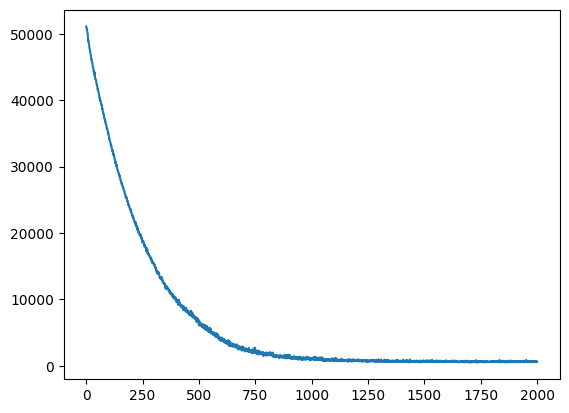

In [217]:
plt.plot(losses)
plt.show()

Навчилась, але на трейн даних значно краще, аніж на тестових.

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

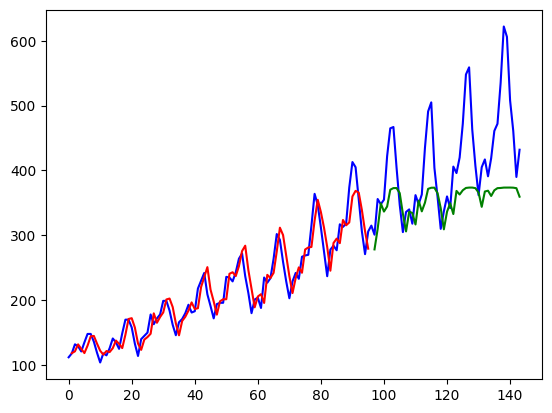

In [239]:
timeseries = df['Passengers'].values
train_size = split_index

def plot_predicts(model):
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts(model)

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [241]:
hidden_size = 100

model2 = AirModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [242]:
losses = fit(epochs, model2)

Epoch 100/2000
Train RMSE: 133.4545, Test RMSE: 323.3793
Epoch 200/2000
Train RMSE: 84.5237, Test RMSE: 259.1473
Epoch 300/2000
Train RMSE: 55.1637, Test RMSE: 212.5292
Epoch 400/2000
Train RMSE: 37.4920, Test RMSE: 170.7953
Epoch 500/2000
Train RMSE: 29.5893, Test RMSE: 142.8054
Epoch 600/2000
Train RMSE: 25.4290, Test RMSE: 121.7314
Epoch 700/2000
Train RMSE: 24.0210, Test RMSE: 107.3581
Epoch 800/2000
Train RMSE: 23.3968, Test RMSE: 98.5211
Epoch 900/2000
Train RMSE: 23.0372, Test RMSE: 89.8305
Epoch 1000/2000
Train RMSE: 23.0522, Test RMSE: 87.2840
Epoch 1100/2000
Train RMSE: 22.5063, Test RMSE: 81.6078
Epoch 1200/2000
Train RMSE: 22.4425, Test RMSE: 80.8957
Epoch 1300/2000
Train RMSE: 22.1447, Test RMSE: 79.7421
Epoch 1400/2000
Train RMSE: 24.0074, Test RMSE: 85.0876
Epoch 1500/2000
Train RMSE: 22.9169, Test RMSE: 78.0772
Epoch 1600/2000
Train RMSE: 22.5945, Test RMSE: 75.5390
Epoch 1700/2000
Train RMSE: 22.8539, Test RMSE: 75.6153
Epoch 1800/2000
Train RMSE: 22.7080, Test RMSE: 7

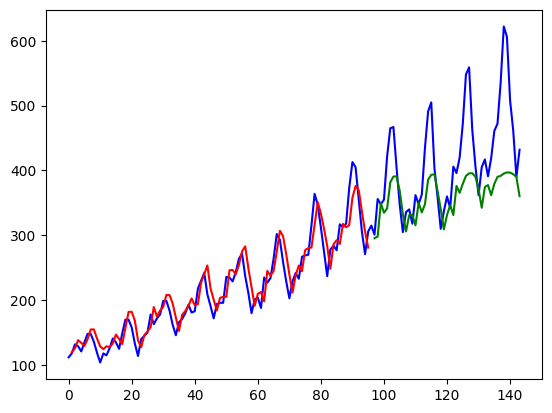

In [243]:
plot_predicts(model2)

Лосс на тестових даних трохи покращився, але незначно.